In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from keras import Model
from sklearn.metrics import classification_report, plot_confusion_matrix, roc_curve, roc_auc_score, confusion_matrix
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, ReLU, Input, BatchNormalization, Conv2D, GlobalMaxPooling2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.data import Dataset
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import os
import glob
import cv2
import random
tf.random.set_seed(3957)
%matplotlib inline

In [2]:
def detailed_report(y_true, y_pred):
  report = {}
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  tpr = tp / (tp + fn)
  spc = tn / (fp + tn)
  ppv = tp / (tp + fp)
  npv = tn / (tn + fn)
  fpr = fp / (fp + tn)
  fdr = fp / (fp + tp)
  fnr = fn / (fn + tp)
  acc = (tp + tn) / (fp + tp + fn + tn)
  f1 = (2 * tp) / ((2 * tp) + fp + fn)
  mcc = ((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
  report["Sensitivity"] = tpr 
  report["Specificity"] = spc
  report["Precision"] = ppv
  report["Negative Predictive Value"] = npv
  report["False Positive Rate"] = fpr
  report["False Discovery Rate"] = fdr
  report["False Negative Rate"] = fnr
  report["Accuracy"] = acc
  report["F1-Score"] = f1
  report["Matthews Correlation Coefficient"] = mcc
  return report

In [3]:
sns.set(style="darkgrid")
plt.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = (10, 10)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
directory = '/content/drive/MyDrive/JSWut'
batch_size = 64

In [6]:
# for file in file_list:
#     if os.stat(file).st_size==0:
#         os.remove(file)

In [7]:
class JSImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, file_type='.js', batch_size=16, shuffle=False, max_dimension=None, X=None, y=None):        
        
        self.directories = directory
        self.batch_size = batch_size
        self.shuffle = shuffle
        if not max_dimension:
          self.max_dimension = 32
        else:
          self.max_dimension = max_dimension
        if not X:
          self.image_paths = [f for f in glob.glob(directory + f"*/*/*{file_type}", recursive=True) if os.path.isfile(f)]
        else:
          self.image_paths = X
        if not y:
          self.class_labels = [1 if 'malicious' in f else 0 for f in self.image_paths]
        else:
          self.class_labels = y

        self.image_paths = np.array(self.image_paths)
        self.class_labels = np.array(self.class_labels)
        self.true_labels = np.array([])

        #index array for shuffling data
        self.idx = np.arange(len(self.image_paths))
        
    
    def __len__(self):
        
        #number of batches in an epoch
        return int(np.ceil(len(self.image_paths)/float(self.batch_size)))
    
    
    def _load_image(self, img_path, save=False):
        max_dim = self.max_dimension      
        img = np.fromfile(img_path, dtype=np.uint8)

        max_dim = int(np.ceil(np.sqrt(len(img))))
        while max_dim ** 2 < len(img):
          max_dim += 1

        max_res = max_dim ** 2
        times = int(np.ceil(max_res/len(img)))
        img = np.tile(img, times)[:max_res]
        img = img.reshape(max_dim, max_dim)
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
        img = np.reshape(img, (256, 256, 1))
        if save:
          with open(f'{img_path}.img', 'wb')  as fp_i:
            np.save(fp_i, img)    
        return img
    
    def on_epoch_end(self):
      if self.shuffle:
        np.random.shuffle(self.idx)


    def __getitem__(self, index):
        batch_image_paths = self.image_paths[self.idx[index *self.batch_size:(index + 1) * self.batch_size]]
        batch_class_labels = self.class_labels[self.idx[index *self.batch_size:(index + 1) * self.batch_size]]

        batch_images = [self._load_image(image_path) for image_path in batch_image_paths]
        self.true_labels = np.append(self.true_labels, batch_class_labels)
        return np.asarray(batch_images), np.asarray(batch_class_labels)


    def transform(self):
        images = [self._load_image(image_path, save=True) for image_path in self.image_paths]
        print('[*] Transformation complete')                 

In [8]:
X = [f for f in glob.glob(directory + "*/*/*.js", recursive=True) if os.path.isfile(f)]
y = [1 if 'malicious' in f else 0 for f in X]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=55555)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.63, random_state=55555)

In [10]:
print(f"""Dataset info:
----------------------------
Training set: {len(X_train)} (Malicious: {y_train.count(1)}, Benign: {y_train.count(0)})
Validation set: {len(X_val)} (Malicious: {y_val.count(1)}, Benign: {y_val.count(0)})
Testing set: {len(X_test)} (Malicious: {y_test.count(1)}, Benign: {y_test.count(0)})
""")

Dataset info:
----------------------------
Training set: 1706 (Malicious: 1305, Benign: 401)
Validation set: 1002 (Malicious: 783, Benign: 219)
Testing set: 677 (Malicious: 537, Benign: 140)



In [11]:
train_gen = JSImageGenerator(directory, batch_size=batch_size, X=X_train, y=y_train)
val_gen = JSImageGenerator(directory, batch_size=batch_size, X=X_val, y=y_val)
test_gen = JSImageGenerator(directory, batch_size=batch_size, X=X_test, y=y_test)

In [12]:
%%script false --no-raise-error
train_gen.transform()

In [13]:
%%script false --no-raise-error
val_gen.transform()

In [14]:
%%script false --no-raise-error
test_gen.transform()

In [15]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
def CNN():
  model = Sequential()
  model.add(Input(shape=(256, 256, 1)))
  model.add(Conv2D(8, (7,7), strides=2, padding='same', kernel_initializer='glorot_uniform', use_bias=True, 
                   kernel_regularizer=regularizers.l2(0.005),
                   bias_regularizer=regularizers.l2(0.005)))
  model.add(MaxPooling2D(pool_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Conv2D(16, (5,5), strides=1, padding='same', kernel_initializer='glorot_uniform', use_bias=True, 
                   kernel_regularizer=regularizers.l2(0.005),
                   bias_regularizer=regularizers.l2(0.005)))
  model.add(MaxPooling2D(pool_size=(3, 3)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Conv2D(32, (3,3), strides=1, padding='same', kernel_initializer='glorot_uniform', use_bias=True, 
                   kernel_regularizer=regularizers.l2(0.005),
                   bias_regularizer=regularizers.l2(0.005)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(10, kernel_initializer='glorot_uniform', use_bias=True, activity_regularizer=regularizers.l2(0.005)))
  model.add(Dense(10, kernel_initializer='glorot_uniform', use_bias=True, activity_regularizer=regularizers.l2(0.005)))
  model.add(Dense(10, kernel_initializer='glorot_uniform', use_bias=True, activity_regularizer=regularizers.l2(0.005)))
  model.add(Dense(1, activity_regularizer=regularizers.l2(0.005)))
  model.add(Activation('sigmoid'))
  return model

In [17]:
cnn = CNN()
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 8)       400       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 8)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 42, 42, 8)        32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 42, 42, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 16)       0

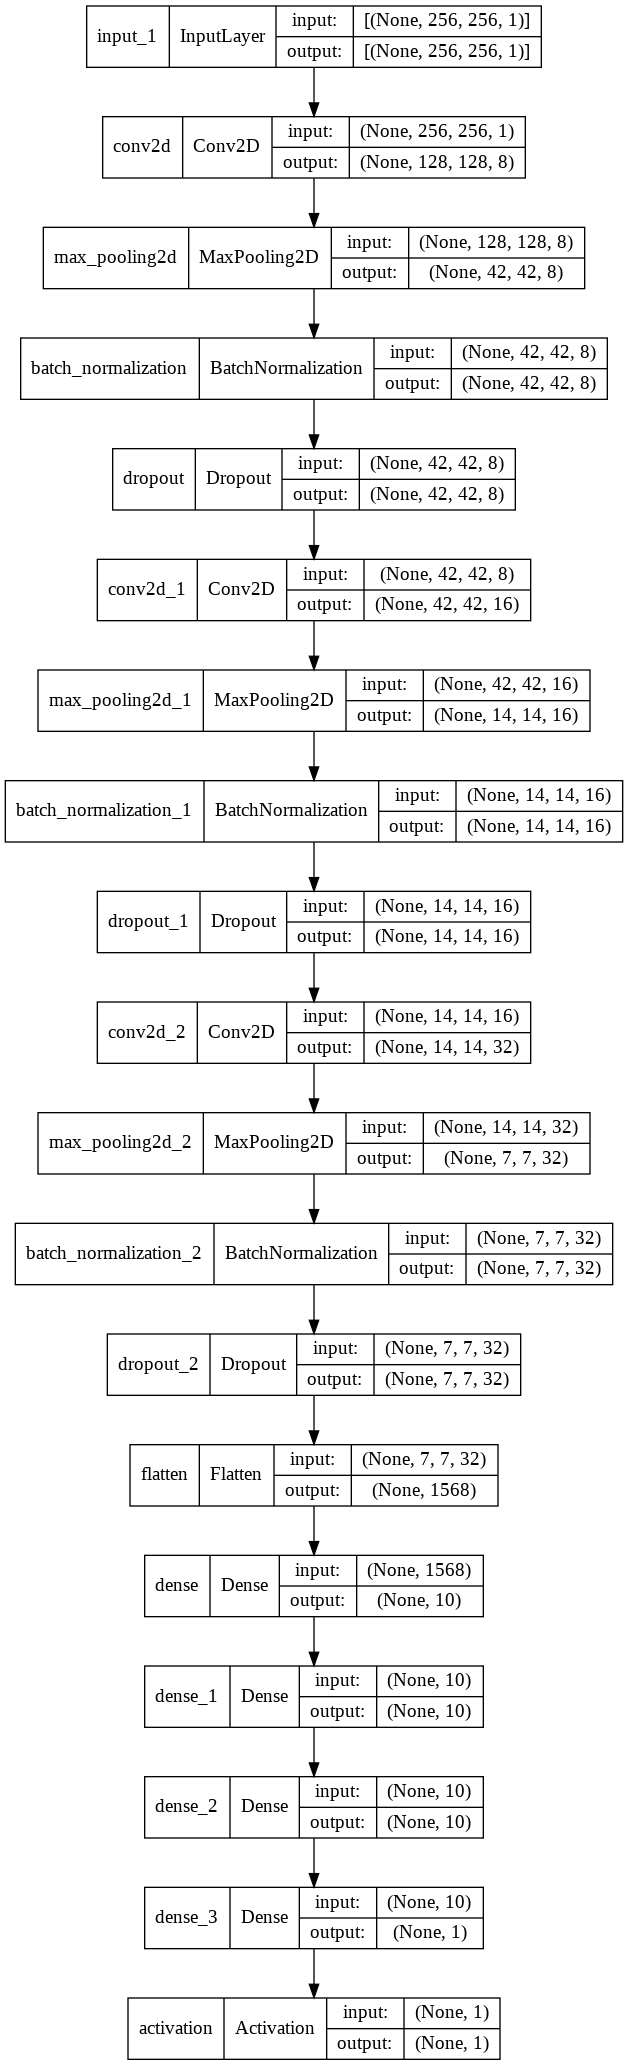

In [18]:
plot_model(cnn, show_shapes=True)

In [19]:
adam = Adam(learning_rate=0.005)
cnn.compile(loss='binary_crossentropy',optimizer=adam, metrics=['acc', f1_m, precision_m, recall_m])

In [20]:
save_name = 'JS-CNN'

In [21]:
# Using raw JavaScript file as image
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/JS-CNN-Custom/JS2IMG_checkpoint_{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_f1_m', mode='max')
csv_logger = CSVLogger(f'/content/drive/MyDrive/JS-CNN-Custom/JS2IMG_training_set_iranalysis_{save_name}.csv',separator=',', append=False)
early_stopper = EarlyStopping(monitor='loss', patience=10, verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=1e-6, cooldown=1, patience=8, min_lr=1e-4, verbose=1)

history = cnn.fit(train_gen, batch_size=batch_size, epochs=50, validation_data=val_gen,callbacks=[checkpointer, csv_logger, early_stopper, lr_reducer])
cnn.save(f'/content/drive/MyDrive/JS-CNN-Custom/{save_name}_JS2IMG_2_cnn.hdf5')

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 1.3299 - acc: 0.8212 - f1_m: 0.8785 - precision_m: 0.8944 - recall_m: 0.8680
Epoch 00001: val_f1_m improved from -inf to 0.04959, saving model to /content/drive/MyDrive/JS-CNN-Custom/JS2IMG_checkpoint_01.hdf5
27/27 [==============================] - 11s 296ms/step - loss: 1.3299 - acc: 0.8212 - f1_m: 0.8785 - precision_m: 0.8944 - recall_m: 0.8680 - val_loss: 31.4650 - val_acc: 0.2385 - val_f1_m: 0.0496 - val_precision_m: 0.6250 - val_recall_m: 0.0261 - lr: 0.0050
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 0.7985 - acc: 0.9127 - f1_m: 0.9424 - precision_m: 0.9338 - recall_m: 0.9527
Epoch 00002: val_f1_m improved from 0.04959 to 0.91436, saving model to /content/drive/MyDrive/JS-CNN-Custom/JS2IMG_checkpoint_02.hdf5
27/27 [==============================] - 7s 273ms/step - loss: 0.7985 - acc: 0.9127 - f1_m: 0.9424 - precision_m: 0.9338 - recall_m: 0.9527 - val_loss: 6.9824 - val_acc: 0.8792 - val_

In [22]:
scores = cnn.evaluate(test_gen, verbose=1)
scores

11/11 [==============================] - 2s 180ms/step - loss: 0.3037 - acc: 0.9261 - f1_m: 0.9550 - precision_m: 0.9193 - recall_m: 0.9948


[0.3037123680114746,
 0.9261447787284851,
 0.9550180435180664,
 0.9193456172943115,
 0.9947500824928284]

In [23]:
# test_gen.true_labels.shape
y_true = test_gen.class_labels

In [24]:
y_pred = cnn.predict(test_gen).ravel()

In [25]:
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

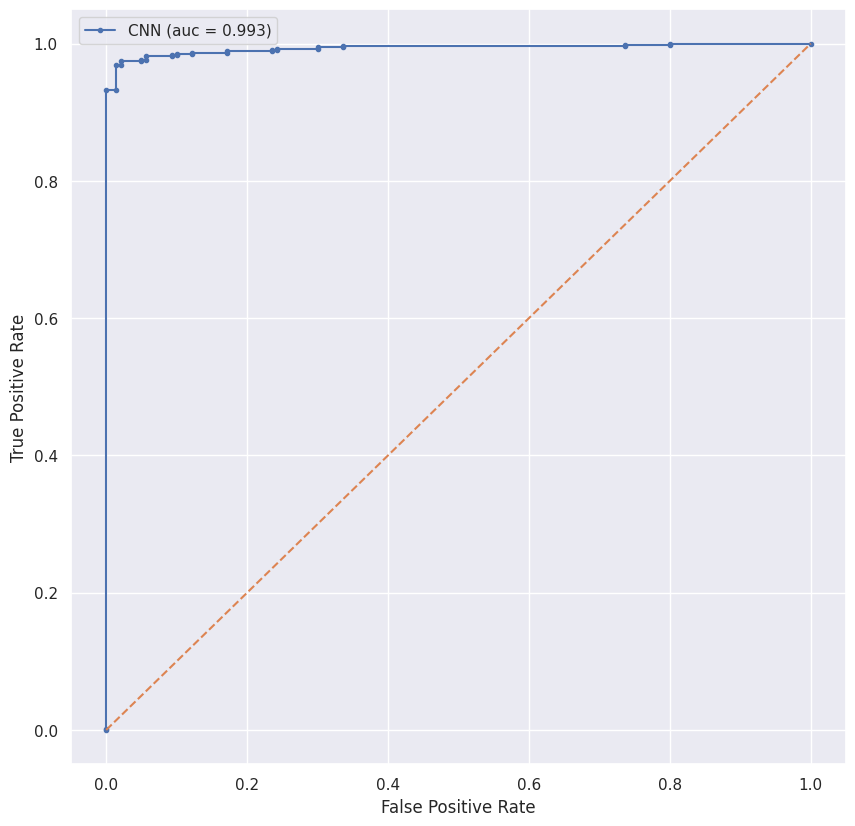

In [26]:
nn_fpr, nn_tpr, _ = roc_curve(y_true, y_pred) # nn_thresholds
nn_auc = roc_auc_score(y_true, y_pred)
plt.plot(nn_fpr, nn_tpr, marker='.', label='CNN (auc = %0.3f)' % nn_auc)
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [27]:
scale = lambda x: 1.0 if (x > 0.5) else 0.0
scale_v = np.vectorize(scale)

In [28]:
y_pred_ = scale_v(y_pred)

In [29]:
print(classification_report(y_true, y_pred_))

              precision    recall  f1-score   support

           0       0.97      0.66      0.79       140
           1       0.92      0.99      0.96       537

    accuracy                           0.93       677
   macro avg       0.94      0.83      0.87       677
weighted avg       0.93      0.93      0.92       677



In [30]:
import json
rep = json.dumps(detailed_report(y_true, y_pred_), sort_keys=True, indent=4)
print(rep)

{
    "Accuracy": 0.9261447562776958,
    "F1-Score": 0.9552772808586762,
    "False Discovery Rate": 0.08089500860585198,
    "False Negative Rate": 0.00558659217877095,
    "False Positive Rate": 0.3357142857142857,
    "Matthews Correlation Coefficient": 0.7647413310326525,
    "Negative Predictive Value": 0.96875,
    "Precision": 0.919104991394148,
    "Sensitivity": 0.994413407821229,
    "Specificity": 0.6642857142857143
}
